In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import seaborn as sns
from math import sqrt

To do list
1. add offset or use peason corr for diff_log entropy data
2. remove KCNT1
3. test loig,diff,original
4. validation
5. separate chips

In [402]:
wt_df = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/wt_data.csv')
wt_df.shape
# # select features
# # basic_info = ['DIV', 'Well', 'Chip_ID', 'NeuronType', 'Trial']
# basic_info = ['Trial']
# # basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
# #             'mean_Burst_Peak', 'Number_Bursts', 'mean_BurstDuration']
# basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
#             'mean_Burst_Peak', 'Number_Bursts', 'mean_Spike_per_Burst']

# advanced_features = ['Mean_FiringRate',	'Mean_SpikeAmplitude',	'Active_area', 'mean_IBI', 'Number_Bursts', 'mean_Spike_per_Burst', 'mean_BurstDuration','mean_Burst_Peak',
#                      'mean_Burst_Peak_Abs','MeanNetworkISI','MeanWithinBurstISI', 'MeanOutsideBurstISI', 'Fanofactor', 'Burst_Peak_Abs']

(694, 28)

In [403]:
other_df = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/other_data.csv')
other_df.shape

(742, 28)

In [404]:
# # dynamic select divs
# # Load the dataset
# wt_data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/wt_data.csv')

# # Filter DIVs between specified limits
# select_div_data = wt_data[(wt_data['DIV'] >= 14) & (wt_data['DIV'] <= 28)]

# # Identify trials
# trials = select_div_data['Trial'].unique()

# count = np.zeros(len(trials))
# # Calculate the number of unique DIVs in each trial
# for i, trial in enumerate(trials):
#     count[i] = select_div_data[select_div_data['Trial'] == trial]['DIV'].nunique()

# # Find the minimum number (integer) of DIVs present across trials (int)
# min_divs_count = int(count.min())
# min_divs_count

In [405]:
# # Center DIV to focus on (it could be set dynamically as well)
# center_div = 21

# # Correct the use of the DataFrame to avoid SettingWithCopyWarning
# results = {}
# for trial in select_div_data['Trial'].unique():
#     trial_data = select_div_data[select_div_data['Trial'] == trial].copy()  # Ensure working on a copy
#     trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
#     trial_data_sorted = trial_data.sort_values(by='Difference')
    
#     # Get the closest DIVs based on the sorted data
#     closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
#     closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']

#     # Select a range of DIVs around the closest DIV
#     possible_divs = trial_data_sorted['DIV'].values
#     div_range = sorted(np.unique(possible_divs))  # Unique and sorted DIVs available in this trial
    
#     # Determine closest possible range around the chosen center
#     center_index = list(div_range).index(closest_div)
#     low = max(0, center_index - min_divs_count // 2)
#     high = min(len(div_range), low + min_divs_count)
    
#     # Adjust if not enough DIVs to the right
#     if high - low < min_divs_count:
#         low = max(0, high - min_divs_count)
    
#     # Final selection of DIVs
#     selected_divs = div_range[low:high]
#     results[trial] = f"Selected DIVs in trial {trial}: {', '.join(map(str, selected_divs))} (Count: {len(selected_divs)})"

# # Display the results
# for trial, result in results.items():
#     print(result)

In [406]:
def threshold_filter(data):
    data_subset = data[data['DIV'] > 7].copy()
    data_outliers = data_subset[data_subset['Active_area'] <= 35]
    data_outliers_unique = data_outliers[['Chip_ID', 'Well','Trial']].drop_duplicates()
    return data_outliers_unique
def z_score_filter(data):
    data_subset = data[data['DIV'] > 7].copy()
    data_subset['Z_score'] = data_subset.groupby(['DIV', 'Trial'])['Active_area'].transform(lambda x: stats.zscore(x))
    z_threshold = 2
    data_z_outliers = data_subset[(data_subset['Z_score'] > z_threshold) | (data_subset['Z_score'] < -z_threshold)]
    data_z_outliers_unique = data_z_outliers[['Chip_ID', 'Well','Trial']].drop_duplicates()
    return data_z_outliers_unique

In [407]:
# combine result from two filters
activity_outlier = pd.concat([threshold_filter(wt_df), z_score_filter(wt_df)])
# remove duplicates
activity_outlier = activity_outlier.drop_duplicates()
print(activity_outlier)
# Remove activity outliers based on combination of Chip_ID and Well
wt_data = wt_df[~wt_df[['Chip_ID', 'Well']].isin(activity_outlier[['Chip_ID', 'Well']]).all(axis=1)]
wt_data.shape

    Chip_ID  Well                     Trial
164  M07301     1    SYNGAP1_T1_C1_03212024
318  M07037     6      KCNT1_T3_C1_03122024
319  M07039     3      KCNT1_T3_C1_03122024
320  M07039     6      KCNT1_T3_C1_03122024
360   16793     1        SPTAN1_T1_07192023
427   16821     1         KCNT1_T1_08082023
643   16793     1       CHD8_T2_C1_08252023
21   M07039     5  CDKL5-E6D_T1_C1_05152024
134  M06691     1    SYNGAP1_T1_C1_03212024
223  M06815     6          ADNP_T2_10262023
272  M06815     4          ADNP_T2_10262023
455   16742     1         KCNT1_T1_08082023
486   16792     1         KCNT1_T1_08082023
535  M07039     2        SHANK3_T1_11222023


(680, 28)

In [408]:
# combine result from two filters
activity_outlier = pd.concat([threshold_filter(other_df), z_score_filter(other_df)])
# remove duplicates
activity_outlier = activity_outlier.drop_duplicates()
print(activity_outlier)
# Remove activity outliers based on combination of Chip_ID and Well
other_data = other_df[~other_df[['Chip_ID', 'Well']].isin(activity_outlier[['Chip_ID', 'Well']]).all(axis=1)]
other_data.shape

    Chip_ID  Well                     Trial
129  M07036     6    SYNGAP1_T1_C1_03212024
130  M07309     1    SYNGAP1_T1_C1_03212024
132  M07309     3    SYNGAP1_T1_C1_03212024
174  M07036     3    SYNGAP1_T1_C1_03212024
179  M07309     2    SYNGAP1_T1_C1_03212024
254  M07037     1      KCNT1_T3_C1_03122024
255  M07037     2      KCNT1_T3_C1_03122024
256  M07037     4      KCNT1_T3_C1_03122024
257  M07037     5      KCNT1_T3_C1_03122024
258  M07038     1      KCNT1_T3_C1_03122024
259  M07038     2      KCNT1_T3_C1_03122024
260  M07038     3      KCNT1_T3_C1_03122024
261  M07038     4      KCNT1_T3_C1_03122024
262  M07038     5      KCNT1_T3_C1_03122024
263  M07038     6      KCNT1_T3_C1_03122024
264  M07039     1      KCNT1_T3_C1_03122024
265  M07039     2      KCNT1_T3_C1_03122024
266  M07039     4      KCNT1_T3_C1_03122024
267  M07039     5      KCNT1_T3_C1_03122024
365   16787     1        SPTAN1_T1_07192023
369   19390     1        SPTAN1_T1_07192023
437   16465     1         KCNT1_

(708, 28)

In [409]:
# dynamic select divs function
def select_divs_around_center(data, lower_limit, upper_limit, center_div):

    # Filter DIVs between specified limits
    select_div_data = data[(data['DIV'] >= lower_limit) & (data['DIV'] <= upper_limit)]

    # Calculate the number of unique DIVs in each trial
    count_divs = select_div_data.groupby('Trial')['DIV'].nunique()

    # Find the minimum number of DIVs present across trials
    min_divs_count = int(count_divs.min())

    # Initialize results dictionary and an empty DataFrame for results
    results = {}
    filtered_dataset = pd.DataFrame()

    # Process each trial to fit within the centered range around the specified center DIV
    for trial in select_div_data['Trial'].unique():
        trial_data = select_div_data[select_div_data['Trial'] == trial].copy()  # Ensure working on a copy
        trial_data['Difference'] = (trial_data['DIV'] - center_div).abs()
        trial_data_sorted = trial_data.sort_values(by='Difference')
        
        # Get the closest DIVs based on the sorted data
        closest_div_index = trial_data_sorted.index[0]  # Getting the index of the closest div
        closest_div = trial_data_sorted.loc[closest_div_index, 'DIV']

        # Select a range of DIVs around the closest DIV
        possible_divs = trial_data_sorted['DIV'].values
        div_range = sorted(np.unique(possible_divs))  # Unique and sorted DIVs available in this trial
        
        # Determine closest possible range around the chosen center
        center_index = list(div_range).index(closest_div)
        low = max(0, center_index - min_divs_count // 2)
        high = min(len(div_range), low + min_divs_count)
        
        # Adjust if not enough DIVs to the right
        if high - low < min_divs_count:
            low = max(0, high - min_divs_count)
        
        # Final selection of DIVs
        selected_divs = div_range[low:high]
        results[trial] = f"Selected DIVs in trial {trial}: {', '.join(map(str, selected_divs))} (Count: {len(selected_divs)})"
        
        # Append the filtered data for these DIVs back into a DataFrame
        trial_filtered_data = trial_data[trial_data['DIV'].isin(selected_divs)]
        filtered_dataset = pd.concat([filtered_dataset, trial_filtered_data], ignore_index=True)

    # Print results and return the filtered dataset
    for trial, result in results.items():
        print(trial, result)
    
    return filtered_dataset

In [410]:
lower_limit = 7
upper_limit = 28
center_div = 21

select_div_data = select_divs_around_center(wt_data, lower_limit, upper_limit, center_div)

CDKL5-E6D_T1_C1_05152024 Selected DIVs in trial CDKL5-E6D_T1_C1_05152024: 13, 16, 20, 23, 27 (Count: 5)
SYNGAP1_T1_C1_03212024 Selected DIVs in trial SYNGAP1_T1_C1_03212024: 12, 15, 19, 22, 26 (Count: 5)
ADNP_T2_10262023 Selected DIVs in trial ADNP_T2_10262023: 14, 18, 21, 25, 27 (Count: 5)
KCNT1_T3_C1_03122024 Selected DIVs in trial KCNT1_T3_C1_03122024: 14, 16, 21, 24, 28 (Count: 5)
SPTAN1_T1_07192023 Selected DIVs in trial SPTAN1_T1_07192023: 13, 16, 20, 23, 27 (Count: 5)
KCNT1_T1_08082023 Selected DIVs in trial KCNT1_T1_08082023: 14, 17, 21, 24, 28 (Count: 5)
ADNP_T3_11072023 Selected DIVs in trial ADNP_T3_11072023: 10, 14, 21, 24, 28 (Count: 5)
SHANK3_T1_11222023 Selected DIVs in trial SHANK3_T1_11222023: 13, 16, 20, 23, 27 (Count: 5)
ADNP_T4_C1_06282024 Selected DIVs in trial ADNP_T4_C1_06282024: 14, 18, 21, 25, 28 (Count: 5)
CHD8_T2_C1_08252023 Selected DIVs in trial CHD8_T2_C1_08252023: 13, 18, 21, 25, 28 (Count: 5)


In [411]:
select_div_other = select_divs_around_center(other_data, lower_limit, upper_limit, center_div)

CDKL5-E6D_T1_C1_05152024 Selected DIVs in trial CDKL5-E6D_T1_C1_05152024: 13, 16, 20, 23, 27 (Count: 5)
SYNGAP1_T1_C1_03212024 Selected DIVs in trial SYNGAP1_T1_C1_03212024: 12, 15, 19, 22, 26 (Count: 5)
ADNP_T2_10262023 Selected DIVs in trial ADNP_T2_10262023: 14, 18, 21, 25, 27 (Count: 5)
KCNT1_T3_C1_03122024 Selected DIVs in trial KCNT1_T3_C1_03122024: 14, 16, 21, 24, 28 (Count: 5)
SPTAN1_T1_07192023 Selected DIVs in trial SPTAN1_T1_07192023: 13, 16, 20, 23, 27 (Count: 5)
KCNT1_T1_08082023 Selected DIVs in trial KCNT1_T1_08082023: 14, 17, 21, 24, 28 (Count: 5)
ADNP_T3_11072023 Selected DIVs in trial ADNP_T3_11072023: 10, 14, 21, 24, 28 (Count: 5)
SHANK3_T1_11222023 Selected DIVs in trial SHANK3_T1_11222023: 13, 16, 20, 23, 27 (Count: 5)
ADNP_T4_C1_06282024 Selected DIVs in trial ADNP_T4_C1_06282024: 14, 18, 21, 25, 28 (Count: 5)
CHD8_T2_C1_08252023 Selected DIVs in trial CHD8_T2_C1_08252023: 13, 18, 21, 25, 28 (Count: 5)


In [412]:
# # check dataset for each trial
# for trial in trials:
#     print(f"Trial: {trial}")
#     print(select_div_data[select_div_data['Trial'] == trial].to_string())

In [413]:
# select features
basic_info = ['Trial','DIV']
basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
                  'mean_Burst_Peak', 'Number_Bursts', 'mean_Spike_per_Burst']
# basic_features = ['Mean_FiringRate', 'Mean_SpikeAmplitude', 'Active_area',
#                   'mean_Burst_Peak', 'Number_Bursts']
basic_data = select_div_data[basic_info + basic_features]

In [414]:
basic_data_other = select_div_other[basic_info + basic_features]

In [415]:
# look at missing values
missing_data = basic_data[basic_data.isna().any(axis=1)]
missing_data

# Remove missing values
basic_data = basic_data.dropna()
# write in csv
basic_data.to_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/basic_data.csv', index=False)

In [416]:
missing_data = basic_data_other[basic_data_other.isna().any(axis=1)]
missing_data
basic_data_other = basic_data_other.dropna()

In [417]:
# average numbers in same div for each trial
combined_data = basic_data.groupby(['Trial', 'DIV']).mean().reset_index()

In [418]:
combined_other = basic_data_other.groupby(['Trial', 'DIV']).mean().reset_index()

In [419]:
unique_trials = combined_data['Trial'].unique()
feature_cols = basic_features

In [420]:
# # 2d matrix (no div info)
# entropy_matrix = np.zeros((len(unique_trials), len(feature_cols)))
# # transfrom one trial data to array
# for trial in unique_trials:
#     trial_data = combined_data[combined_data['Trial'] == trial]
#     trial_arr = trial_data[feature_cols].values
#     # take the mean of each feature
#     mean_data = np.mean(trial_arr, axis=0)
#     print(mean_data)
#     # store in matrix
#     index = np.where(unique_trials == trial)
#     entropy_matrix[index] = mean_data

In [421]:
entropy_trials = np.array(sorted(combined_data['Trial'].unique()))

**Mahalanobis distance matrix**

In [422]:
# config dist_matrix matrix, with div info

# Count the number of DIVs in the first trial
count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the dist_matrix matrix
dist_matrix = np.zeros((num_trials, columns_per_trial))


# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_data[combined_data['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    dist_matrix[idx, :] = trial_features

In [423]:
# reshape the matrix to reduce dimension, avoid sigularity of covariance matrix
reshaped_matrix = dist_matrix.reshape(num_trials, num_features, num_divs)

# Calculate the average across DIVs for each feature in each trial
dist_matrix = reshaped_matrix.mean(axis=2)
dist_matrix

array([[3.55234971e+00, 8.52280868e+01, 9.14822574e+01, 9.44237825e+00,
        1.17611765e+02, 8.62493205e+03],
       [2.29309806e+00, 5.23282441e+01, 6.48440000e+01, 5.03899172e+00,
        1.16300000e+02, 4.74251370e+03],
       [1.44100411e+00, 9.38095269e+01, 7.21323232e+01, 8.52611706e+00,
        7.45333333e+01, 4.98809119e+03],
       [2.17738357e+00, 1.09902409e+02, 9.04933884e+01, 7.49616127e+00,
        1.29185455e+02, 3.99359676e+03],
       [2.45822624e+00, 7.23323574e+01, 6.49858444e+01, 7.96309829e+00,
        9.59222222e+01, 5.30852043e+03],
       [2.66880007e+00, 9.17166469e+01, 7.94018182e+01, 1.16838102e+01,
        7.94000000e+01, 1.06915670e+04],
       [2.31601524e+00, 5.59595837e+01, 3.56083333e+01, 5.60953319e+00,
        3.90333333e+01, 4.91374341e+03],
       [2.30891796e+00, 1.04375976e+02, 9.47118611e+01, 8.16546351e+00,
        1.00663889e+02, 5.06843275e+03],
       [3.52713223e+00, 7.77255775e+01, 7.27585000e+01, 9.68016016e+00,
        1.03725000e+02, 

In [424]:
# apply mahalanobis distance for outlier detection, using dist_matrix

# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(dist_matrix, rowvar=False)

mean_distr = np.mean(dist_matrix, axis=0)

# # Regularization term
# regularization_term = 0.001  # Small positive value

# # Dimension of the matrix (number of features)
# d = cov_matrix.shape[0]

# # Add regularization
# regularized_cov_matrix = cov_matrix + np.eye(d) * regularization_term

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each observation
distances = []

for i in range(dist_matrix.shape[0]):
    x = dist_matrix[i]
    md = mahalanobis(x, mean_distr, inv_cov_matrix)
    distances.append(md)

# Set the significance level
alpha = 0.05
df = dist_matrix.shape[1] # Degrees of freedom
threshold = chi2.ppf((1 - alpha), df)

# Flag observations exceeding the threshold
outliers = np.array(distances) > np.sqrt(threshold)
outlier_trials = entropy_trials[outliers]
print("Outlier Trials based on Mahalanobis Distance:", outlier_trials)

Outlier Trials based on Mahalanobis Distance: []


In [425]:
# calc feature contributions towards outlier dispersions
def calculate_feature_contributions(data_matrix, mean_vector, inv_cov):
    n_samples = data_matrix.shape[0] # Number of rows
    n_features = data_matrix.shape[1] # Number of columns
    contributions = np.zeros((n_samples, n_features))
    
    for i in range(n_samples):
        diff = data_matrix[i] - mean_vector
        # Compute the product for each feature contribution
        for j in range(n_features):
            # contributions[i, j] = diff[j] * np.dot(inv_cov[j], diff)
            # contributions[i, j] = (diff[j] * np.dot(inv_cov[j], diff)) ** 2
            contributions[i, j] = abs(diff[j] * np.dot(inv_cov[j], diff))
    return contributions


# Calculate all contributions
all_contributions = calculate_feature_contributions(dist_matrix, mean_distr, inv_cov_matrix)
all_contributions

array([[4.98630011e+00, 2.37204467e-01, 2.19316066e+00, 7.57888176e-01,
        9.62057096e-01, 1.28298008e+00],
       [4.51086420e-01, 6.70692677e+00, 1.73464229e+00, 2.42623417e+00,
        4.33369372e-01, 9.23611878e-01],
       [3.22273853e+00, 2.69683738e-01, 8.62001861e-02, 6.49645052e-02,
        6.09267988e-01, 1.09166682e+00],
       [1.94934200e-01, 6.89971445e+00, 6.09493038e+00, 3.15231225e-01,
        5.58261547e+00, 9.21236287e-01],
       [1.02471101e-01, 4.92642671e-01, 2.45970703e+00, 7.99606370e-01,
        5.11610002e-01, 1.55809466e+00],
       [1.51792872e-01, 1.07923297e-01, 3.26768622e-02, 2.54255441e+00,
        1.99981746e-01, 2.21967535e-01],
       [3.17094416e-01, 2.33644276e+00, 3.56132239e+00, 2.05943959e+00,
        4.24809544e+00, 4.74270868e-01],
       [5.49370424e-02, 1.39100712e+00, 8.65215735e+00, 4.75978865e-01,
        1.49067225e+00, 6.68950096e-01],
       [1.81194185e+00, 3.17618662e-01, 3.53562323e-02, 1.04600083e+00,
        3.73352768e-01, 

In [426]:
# use dist_matrix, map and generate dict
def map_and_rank_contributions(dist_matrix, all_contributions, outliers, basic_features):
    # Extract the contributions for outlier trials
    outlier_contributions = all_contributions[outliers, :]
    outlier_names = np.array(entropy_trials)[outliers]  # Assuming entropy_trials contains trial names

    # Instead of ranking, just pair features with their contributions directly
    contributions_by_outlier = {}
    for index, trial_name in enumerate(outlier_names):
        contributions = outlier_contributions[index, :]
        contributions_by_outlier[trial_name] = [(basic_features[i], contributions[i]) for i in range(len(basic_features))]
    
    return contributions_by_outlier

contributions_dict = map_and_rank_contributions(dist_matrix, all_contributions, np.array(outliers), basic_features)
contributions_dict

{}

/var/folders/hz/mtvvz9t52kxgqcx423vlrhx00000gn/T/ipykernel_38543/1986024077.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Trials', bbox_to_anchor=(1.05, 1), loc='upper left')


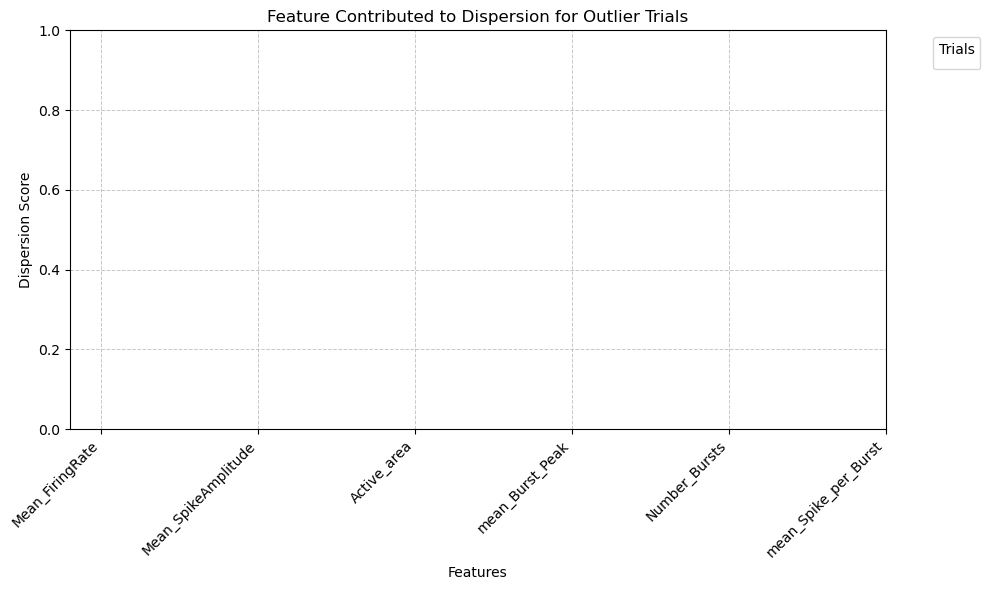

In [427]:
# Plotting the Contributions
trial_names = list(contributions_dict.keys())

# Prepare data for plotting
contributions_data = np.array([[contribution for _, contribution in contributions_dict[trial]] for trial in trial_names])

# Plotting parameters
num_features = len(basic_features)
num_trials = len(trial_names)
x = np.arange(num_features)  # X-axis positions for each feature
bar_width = 0.2  # Width of each bar

plt.figure(figsize=(10, 6))

# Plot each trial's contributions as bars
for i in range(num_trials):
    plt.bar(
        x + i * bar_width,  # Shift bars for each trial
        contributions_data[i],  # Contributions for the current trial
        width=bar_width, 
        label=trial_names[i], 
        align='center'
    )

# Configure x-axis labels and ticks
plt.xticks(x + bar_width, basic_features, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Dispersion Score')
plt.title('Feature Contributed to Dispersion for Outlier Trials')

# Add grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(title='Trials', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Entropy**


In [429]:
# config entropy matrix, with div info

count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the entropy matrix
entropy_matrix = np.zeros((num_trials, columns_per_trial))


# Define your trials - assuming your trials are uniquely and sequentially numbered
entropy_trials = np.array(sorted(combined_data['Trial'].unique()))

# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_data[combined_data['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    entropy_matrix[idx, :] = trial_features

# Print the matrix to see the result
print(entropy_matrix)

[[3.32629733e+00 4.03618434e+00 4.09020030e+00 3.48824346e+00
  2.82082310e+00 7.43976887e+01 8.29795256e+01 8.90565478e+01
  8.82713278e+01 9.14353440e+01 8.86556250e+01 9.27411765e+01
  9.41005882e+01 9.22062500e+01 8.97076471e+01 8.17505118e+00
  1.05080446e+01 1.01386649e+01 9.68192707e+00 8.70820351e+00
  9.78125000e+01 1.24588235e+02 1.28529412e+02 1.21187500e+02
  1.15941176e+02 1.06234144e+04 1.16313388e+04 8.00594211e+03
  7.31849044e+03 5.54547446e+03]
 [1.72896417e+00 2.31979544e+00 2.51485583e+00 2.31361208e+00
  2.58826278e+00 4.36795270e+01 4.97360409e+01 5.55124405e+01
  5.45452080e+01 5.81680038e+01 4.01700000e+01 6.65150000e+01
  7.32250000e+01 7.03200000e+01 7.39900000e+01 3.11239319e+00
  4.81032940e+00 5.42693748e+00 5.45226155e+00 6.39303697e+00
  1.09500000e+02 1.03000000e+02 1.15500000e+02 1.24000000e+02
  1.29500000e+02 1.49468372e+03 5.48957157e+03 4.85337133e+03
  6.45753306e+03 5.41740881e+03]
 [1.88643113e+00 1.51972768e+00 1.41487499e+00 1.19928496e+00
  1.

In [430]:
import numpy as np
import matplotlib.pyplot as plt

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs

feature_cols = basic_features

# Plotting function
def plot_feature_entropy(entropy_matrix, feature_index, num_divs, num_trials, feature_name, trials):
    # Extract the relevant section of the matrix for the selected feature
    feature_data = entropy_matrix[:, feature_index * num_divs : (feature_index + 1) * num_divs]
    
    # Calculate reference (mean and std across trials) for each DIV
    mean_data = np.mean(feature_data, axis=0)
    std_data = np.std(feature_data, axis=0)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot bars for each trial at each DIV
    width = 0.08  # Width of each trial's bar
    x = np.arange(num_divs)  # Positions for each DIV
    
    # Plot each trial's data
    for i in range(num_trials):
        ax.bar(x + i * width, feature_data[i, :], width, label=trials[i])
    
    # Plot the reference bar with error bars (mean ± std)
    ax.errorbar(x + (num_trials * width) / 2, mean_data, yerr=std_data, fmt='o', color='black', 
                ecolor='gray', capsize=5, label='Mean ± STD')
    
    # Customize the plot
    ax.set_title(f'Entropy Matrix for Feature: {feature_name}')
    ax.set_xlabel('DIV')
    ax.set_ylabel('Entropy Value')
    ax.set_xticks(x + (num_trials * width) / 2)
    ax.set_xticklabels([f'DIV_{i+1}' for i in range(num_divs)])
    ax.legend(title='Trials')
    
    # Show the plot
    plt.show()

In [431]:
# # Loop over each feature and plot
# for feature_index, feature_name in enumerate(feature_cols):
#     plot_feature_entropy(entropy_matrix, feature_index, num_divs, num_trials, 
#                          feature_name, entropy_trials)

In [432]:
def plot_feature_entropy_line(entropy_matrix, feature_index, num_divs, num_trials, feature_name, trials):
    # Extract the relevant section of the matrix for the selected feature
    feature_data = entropy_matrix[:, feature_index * num_divs: (feature_index + 1) * num_divs]
    
    # Calculate reference (mean and standard deviation across trials) for each DIV
    mean_data = np.mean(feature_data, axis=0)
    std_data = np.std(feature_data, axis=0)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(num_divs)  # Positions for each DIV
    
    # Plot each trial's data as a line
    for i in range(num_trials):
        ax.plot(x, feature_data[i, :], marker='o', linestyle='-', label=f'{trials[i]}')
    
    # Plot the mean as a bold line and the std deviation as a shaded area
    ax.plot(x, mean_data, color='black', linewidth=2, label='Mean')
    ax.fill_between(x, mean_data - 1.5*std_data, mean_data + 1.5*std_data, color='gray', alpha=0.3, label='Mean ± 1.5 STD')
    
    # Customize the plot
    ax.set_title(f'Feature Analysis Across Trials: {feature_name}')
    ax.set_xlabel('Selected DIVs centered at DIV 21')
    ax.set_ylabel(f'{feature_name} Value')

    # Specific DIVs as requested
    div_labels = [14, 18, 21, 25, 27]  # Specific DIVs to display on X-axis
    ax.set_xticks(np.linspace(0, num_divs-1, len(div_labels)))  # Set the positions for the labels
    ax.set_xticklabels([f'{div}' for div in div_labels])  # Set the custom labels

    # Adjust legend
    legend = ax.legend(title='mean value acorss all chips', loc='upper right', fontsize='small', 
                       bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)
    plt.subplots_adjust(right=0.85) 
    # save figures use it's feature name as png
    plt.savefig(f'/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/feature_analysis/{feature_name}_analysis.png')
    # Show the plot
    plt.show()
    return fig

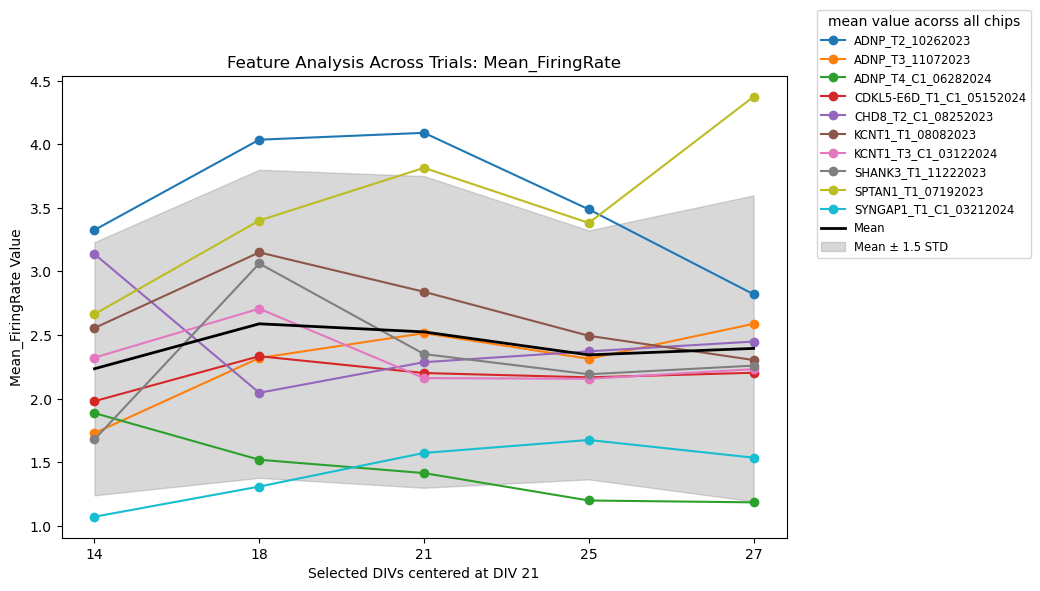

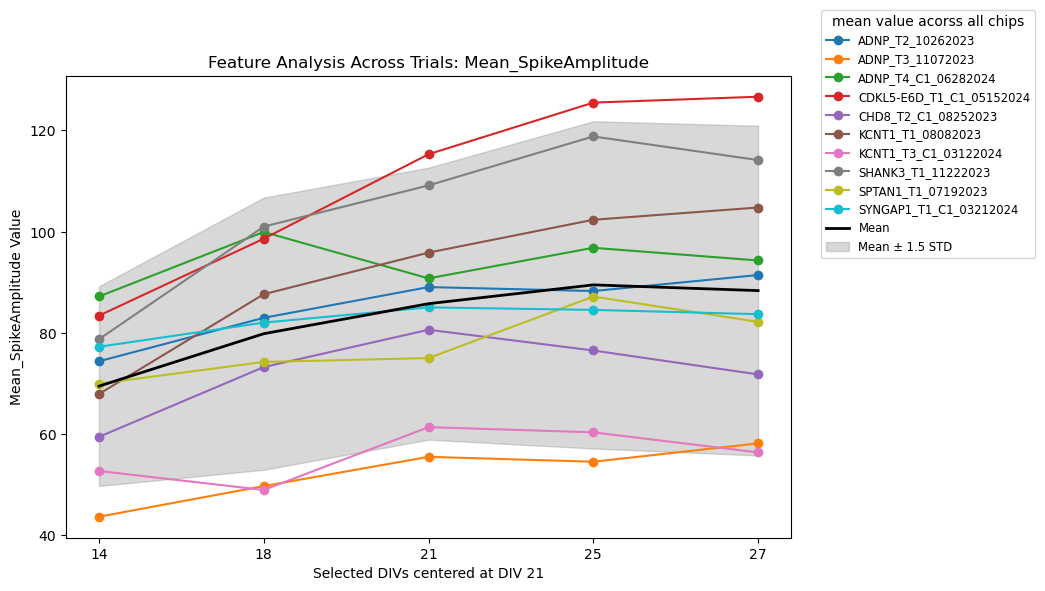

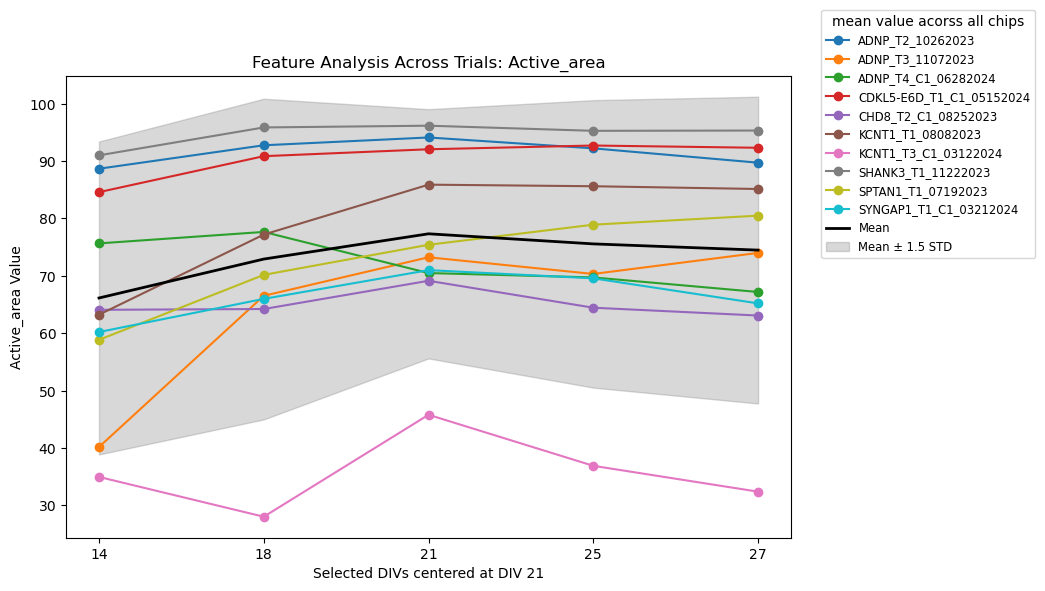

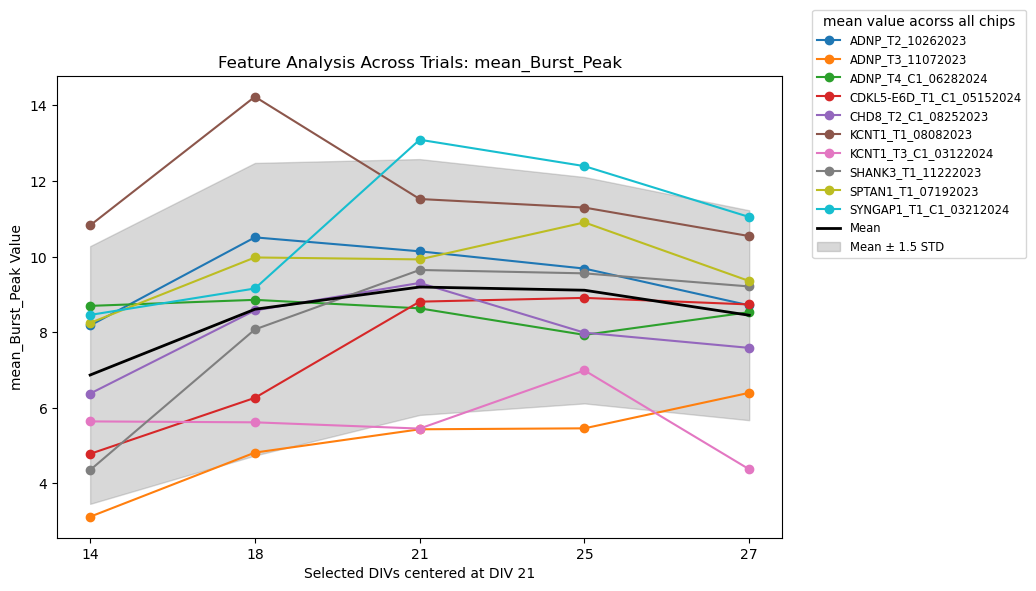

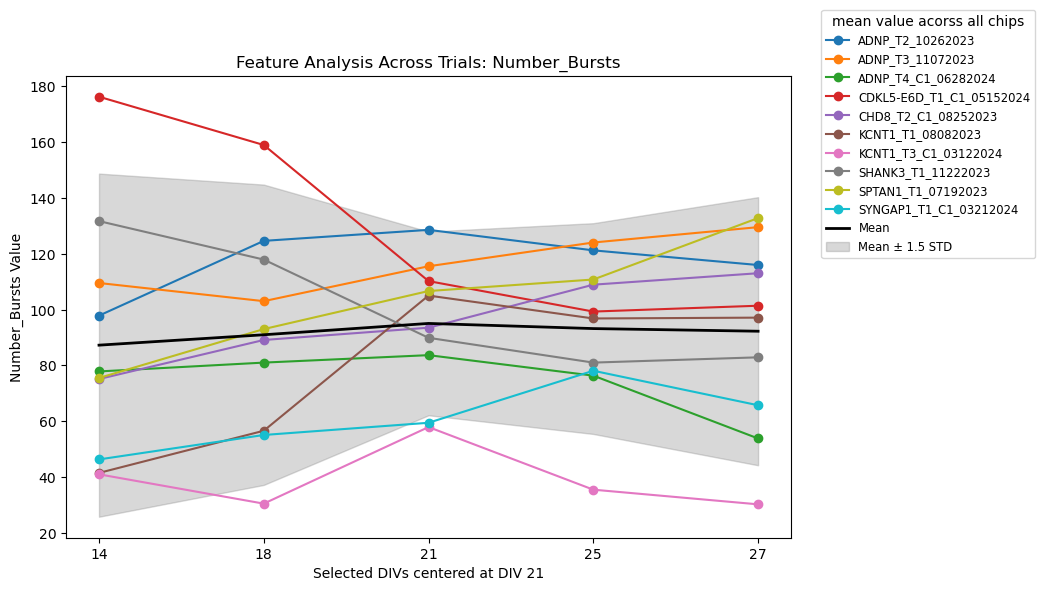

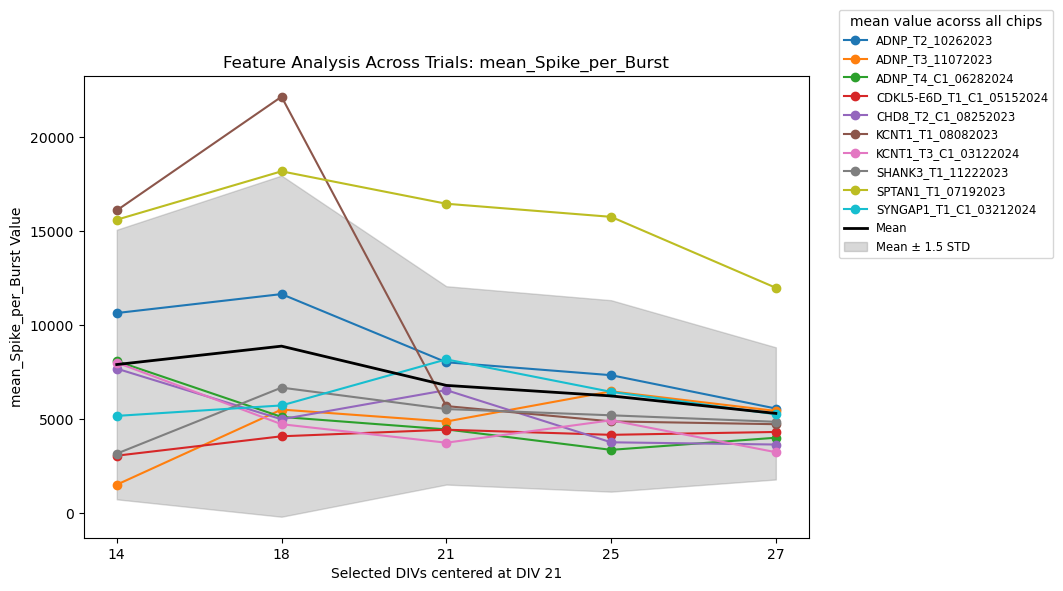

In [433]:
for feature_index, feature_name in enumerate(feature_cols):
    plot_feature_entropy_line(entropy_matrix, feature_index, num_divs, num_trials, 
                         feature_name, entropy_trials)

In [434]:
# # Calculate IQR for each feature within each trial and DIV
# def calculate_iqr(group):
#     return group.quantile(0.75) - group.quantile(0.25)
# iqr_data = basic_data.groupby(['Trial', 'DIV'])[feature_cols].agg(calculate_iqr).reset_index()

In [435]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_feature_with_iqr(entropy_matrix, feature_index, num_divs, num_trials, feature_name, trials):
#     # Extract the relevant section of the matrix for the selected feature
#     feature_data = entropy_matrix[:, feature_index * num_divs: (feature_index + 1) * num_divs]

#     # Calculate reference (mean and standard deviation across trials) for each DIV
#     mean_data = np.mean(feature_data, axis=0)
#     std_data = np.std(feature_data, axis=0)
    
#     # Set up the plot
#     fig, ax = plt.subplots(figsize=(10, 6))
#     x = np.arange(num_divs)  # Positions for each DIV
    
#     # Plot each trial's data as a line and IQR as vertical lines
#     for i in range(num_trials):
#         ax.plot(x, feature_data[i, :], marker='o', linestyle='-', label=f'{trials[i]}')

#         # Assuming IQR values are stored immediately after the mean values in the matrix
#         # Plot IQR data as vertical lines
#         for j in range(num_divs):
#             lower_bound = feature_data[i, j] - feature_data[i, j] / 2  # Adjust according to actual IQR calculation
#             upper_bound = feature_data[i, j] + feature_data[i, j] / 2
#             ax.vlines(x[j], lower_bound, upper_bound, color='purple', alpha=0.5)

#     # Plot the mean as a bold line and the std deviation as a shaded area
#     ax.plot(x, mean_data, color='black', linewidth=2, label='Mean')
#     ax.fill_between(x, mean_data - std_data, mean_data + std_data, color='gray', alpha=0.3, label='Mean ± STD')
    
#     # Customize the plot
#     ax.set_title(f'Feature Analysis Across Trials: {feature_name}')
#     ax.set_xlabel('Selected DIVs centered at DIV 21')
#     ax.set_ylabel(f'{feature_name} Value')

#     # Specific DIVs as requested
#     div_labels = [14, 18, 21, 25, 27]  # Specific DIVs to display on X-axis
#     ax.set_xticks(np.linspace(0, num_divs-1, len(div_labels)))  # Set the positions for the labels
#     ax.set_xticklabels([f'{div}' for div in div_labels])  # Set the custom labels

#     # Adjust legend
#     legend = ax.legend(title='Data Analysis', loc='upper right', fontsize='small', 
#                        bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure)
#     plt.subplots_adjust(right=0.85) 

#     # Show the plot
#     plt.show()

# # Iterate over each feature to plot
# for feature_index, feature_name in enumerate(feature_cols):
#     plot_feature_with_iqr(iqr_matrix, feature_index, num_divs, num_trials, 
#                          feature_name, entropy_trials)


In [436]:
# # config entropy matrix, with div info

# count_divs = combined_data.groupby('Trial')['DIV'].count().iloc[0]

# num_trials = len(unique_trials)
# num_features = len(feature_cols)
# num_divs = count_divs
# columns_per_trial = num_divs * num_features

# # Initialize the entropy matrix
# iqr_matrix = np.zeros((num_trials, columns_per_trial))


# # Define your trials - assuming your trials are uniquely and sequentially numbered
# entropy_trials = np.array(sorted(iqr_data['Trial'].unique()))

# # Populate the matrix
# for idx, trial in enumerate(entropy_trials):
#     # Filter data for the current trial
#     trial_data = iqr_data[iqr_data['Trial'] == trial]
#     trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
#     # Flatten the trial data across DIVs for each feature
#     trial_features = []
#     for feature in feature_cols:
#         trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
#     # Store in the matrix
#     iqr_matrix[idx, :] = trial_features

# # Print the matrix to see the result
# print(iqr_matrix)

In [437]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_feature_with_individual_and_overall_stats(feature_name):
#     fig, ax = plt.subplots(figsize=(12, 8))

#     # Get a sorted list of unique DIVs from the overall dataset for consistent plotting
#     all_divs = sorted(basic_data['DIV'].unique())
#     x = np.arange(len(all_divs))  # Position indices for DIVs

#     # Iterate over each trial
#     for trial in sorted(unique_trials):
#         trial_data = individual_stats[individual_stats['Trial_'] == trial]
#         trial_data = trial_data.sort_values('DIV_')

#         # Match trial data with the all_divs array to handle missing DIVs
#         y = np.full_like(x, np.nan, dtype=np.float64)  # Initialize with NaNs
#         # Place mean values into the correct positions based on actual DIVs present in the trial
#         for div, mean in zip(trial_data['DIV_'], trial_data[f'{feature_name}_mean']):
#             if div in all_divs:
#                 y[np.where(all_divs == div)[0][0]] = mean  # Locate the index for the DIV and replace NaN

#         # Plotting the mean line for the trial
#         ax.plot(x, y, marker='o', linestyle='-', label=f'{trial} Mean')

#     # Plotting overall statistics for each DIV
#     overall_stats_sorted = overall_stats.sort_values('DIV_')
#     overall_means = [overall_stats_sorted[overall_stats_sorted['DIV_'] == div][f'{feature_name}_mean'].values[0] if div in overall_stats_sorted['DIV_'].values else np.nan for div in all_divs]
#     overall_stds = [overall_stats_sorted[overall_stats_sorted['DIV_'] == div][f'{feature_name}_std'].values[0] if div in overall_stats_sorted['DIV_'].values else np.nan for div in all_divs]

#     ax.plot(x, overall_means, color='black', linewidth=2, label='Overall Mean')
#     ax.fill_between(x, np.array(overall_means) - np.array(overall_stds), np.array(overall_means) + np.array(overall_stds), color='gray', alpha=0.3, label='Overall STD')

#     # Customize the plot
#     ax.set_title(f'Feature Analysis Across DIVs: {feature_name}')
#     ax.set_xlabel('DIV')
#     ax.set_ylabel(f'{feature_name} Value')
#     ax.set_xticks(x)
#     ax.set_xticklabels([f'DIV {div}' for div in all_divs])
    
#     ax.legend(title='Trial Data and Overall Stats', loc='upper right', fontsize='small', bbox_to_anchor=(1.1, 1))
#     plt.subplots_adjust(right=0.85)

#     plt.show()

# # Assuming 'unique_trials' is defined as the list of unique trial identifiers
# unique_trials = individual_stats['Trial_'].unique()
# plot_feature_with_individual_and_overall_stats('Active_area')  # Replace 'Active_area' with the actual feature name from your dataset


In [450]:
# # Load the data
# div_data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/div21_feature/wt_data.csv')
# div21_data = div_data[div_data['DIV'] == 21]
# # find activity outliers
# activity_outlier = z_score_filter(div21_data)

# # Remove activity outliers based on combination of Chip_ID and Well
# div21_data = div21_data[~div21_data[['Chip_ID', 'Well']].isin(activity_outlier[['Chip_ID', 'Well']]).all(axis=1)]

# # Define output types
# output_types = basic_features


# # Get unique trials from the data and modify names
# unique_trials = div21_data['Trial'].unique()
# modified_trials = ['_'.join(trial.split('_')[:2]) for trial in unique_trials]  # Modify here

# # Create a subplot grid
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
# fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust horizontal and vertical spaces

# for index, output_type in enumerate(output_types):
#     ax = axes[index // 3, index % 3]  # Determine the position of the subplot

#     output_means = []
#     output_errs = []
#     output_all_data = []

#     # Collect data for plotting
#     for i, trial in enumerate(unique_trials):
#         temp_df = div21_data[div21_data['Trial'] == trial]
#         values = temp_df[output_type].dropna()

#         mean_val = values.mean()
#         stderr_val = values.sem()  # Standard error of the mean

#         output_means.append(mean_val)
#         output_errs.append(stderr_val)
#         output_all_data.append(values)

#     # Plotting on designated axes
#     x_positions = np.arange(len(modified_trials))
#     bars = ax.bar(x_positions, output_means, yerr=output_errs, capsize=3, color='royalblue', label='Mean with SEM')

#     # Add scatter plot inside the bars
#     for i, trial_data in enumerate(output_all_data):
#         jitter = np.random.normal(0, 0.04, size=len(trial_data))
#         ax.scatter(x_positions[i] + jitter, trial_data, color='darkblue', alpha=0.7, s=10)

#     # Aesthetics
#     ax.set_xticks(x_positions)
#     ax.set_xticklabels(modified_trials, rotation=45, ha="right")
#     ax.set_title(f"{output_type} at DIV 21", fontsize=14)
#     ax.set_xlabel('Trial', fontsize=12)
#     ax.set_ylabel(f"{output_type}", fontsize=12)

# plt.show()

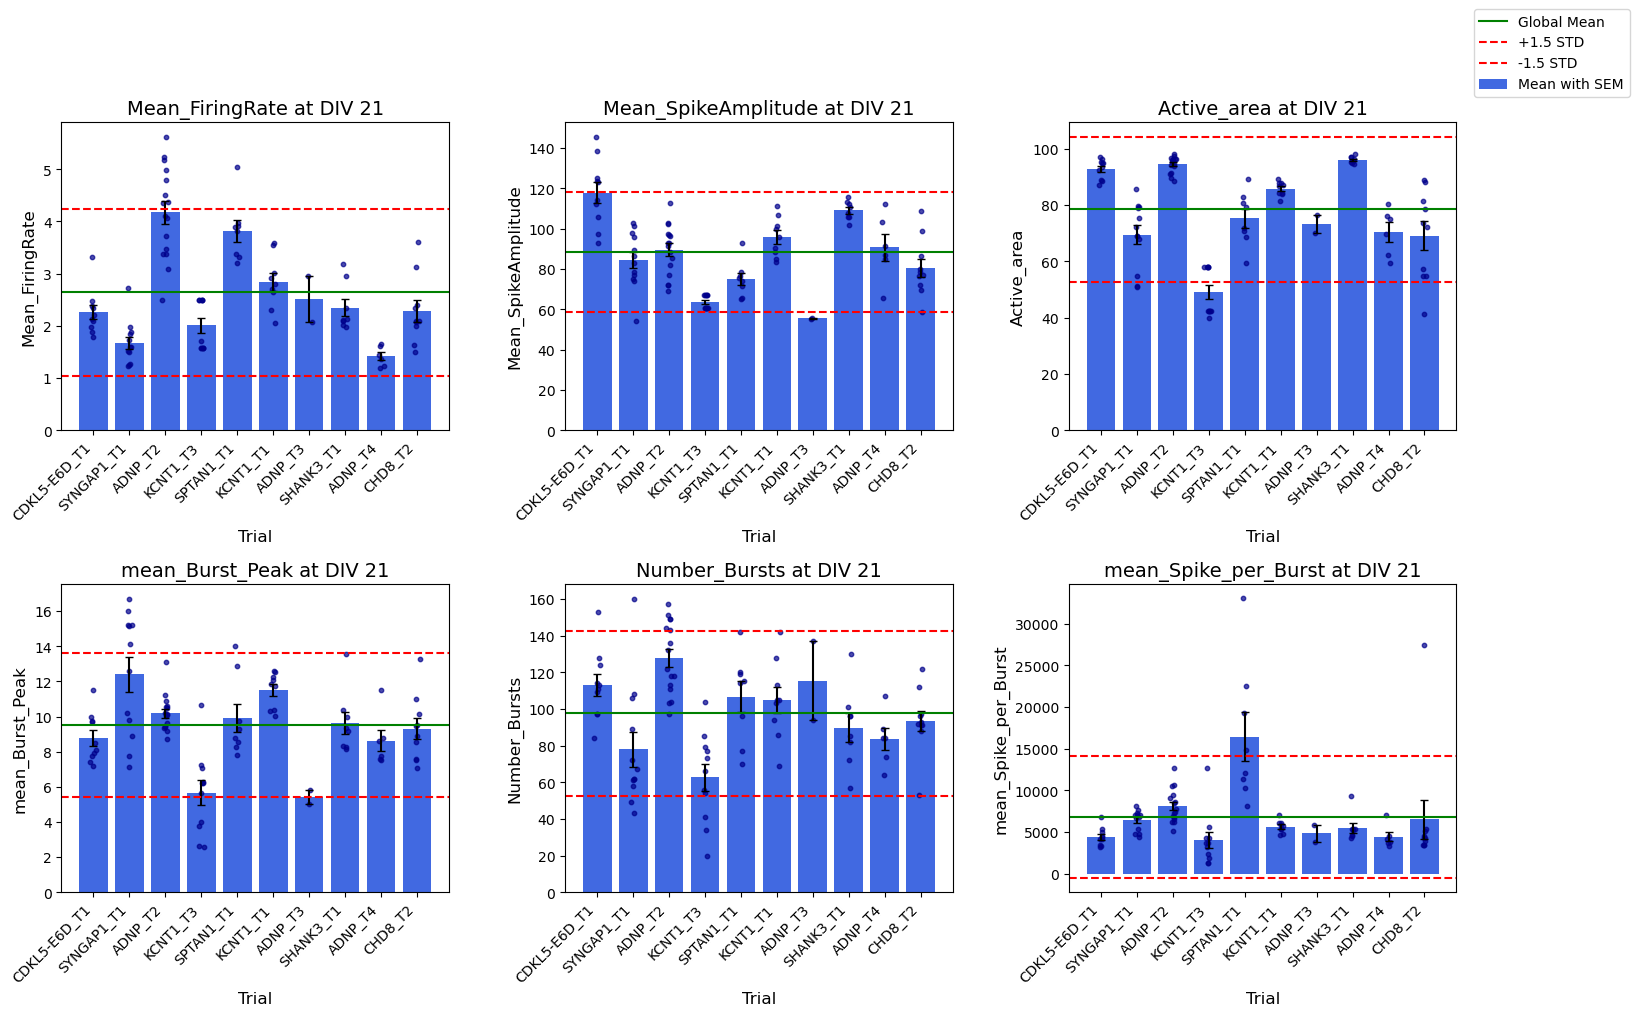

In [453]:
# Load the data
div_data = pd.read_csv('/Users/liufanling/Library/CloudStorage/OneDrive-Personal/1 UC DAVIS/CSRA/QualityCheck/HomoCheck/div21_feature/wt_data.csv')
div21_data = div_data[div_data['DIV'] == 21]
# find activity outliers
activity_outlier = z_score_filter(div21_data)

# Remove activity outliers based on combination of Chip_ID and Well
div21_data = div21_data[~div21_data[['Chip_ID', 'Well']].isin(activity_outlier[['Chip_ID', 'Well']]).all(axis=1)]

# Define output types
output_types = basic_features
# Get unique trials from the data and modify names
unique_trials = div21_data['Trial'].unique()
modified_trials = ['_'.join(trial.split('_')[:2]) for trial in unique_trials]

# Create a subplot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust horizontal and vertical spaces

# Calculate global statistics for all features
all_data_stats = {feature: {} for feature in output_types}
for feature in output_types:
    all_feature_data = div21_data[feature].dropna()
    all_data_stats[feature]['mean'] = all_feature_data.mean()
    all_data_stats[feature]['std'] = all_feature_data.std()

for index, output_type in enumerate(output_types):
    ax = axes[index // 3, index % 3]  # Determine the position of the subplot

    output_means = []
    output_errs = []
    output_all_data = []

    # Collect data for plotting
    for i, trial in enumerate(unique_trials):
        temp_df = div21_data[div21_data['Trial'] == trial]
        values = temp_df[output_type].dropna()

        mean_val = values.mean()
        stderr_val = values.sem()  # Standard error of the mean

        output_means.append(mean_val)
        output_errs.append(stderr_val)
        output_all_data.append(values)

    # Plotting on designated axes
    x_positions = np.arange(len(modified_trials))
    bars = ax.bar(x_positions, output_means, yerr=output_errs, capsize=3, color='royalblue', label='Mean with SEM')

    # Add scatter plot inside the bars
    for i, trial_data in enumerate(output_all_data):
        jitter = np.random.normal(0, 0.04, size=len(trial_data))
        ax.scatter(x_positions[i] + jitter, trial_data, color='darkblue', alpha=0.7, s=10)

    # Plot mean and std lines for all trials
    global_mean = all_data_stats[output_type]['mean']
    global_std = all_data_stats[output_type]['std']

    ax.axhline(y=global_mean, color='green', linestyle='-', label='Global Mean')
    ax.axhline(y=global_mean + 1.5 * global_std, color='red', linestyle='--', label='+1.5 STD')
    ax.axhline(y=global_mean - 1.5 * global_std, color='red', linestyle='--', label='-1.5 STD')

    # Aesthetics
    ax.set_xticks(x_positions)
    ax.set_xticklabels(modified_trials, rotation=45, ha="right")
    ax.set_title(f"{output_type} at DIV 21", fontsize=14)
    ax.set_xlabel('Trial', fontsize=12)
    ax.set_ylabel(f"{output_type}", fontsize=12)

# Add legends
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
plt.show()


In [442]:
for t in unique_trials:
    print(t)

CDKL5-E6D_T1_C1_05152024
SYNGAP1_T1_C1_03212024
ADNP_T2_10262023
KCNT1_T3_C1_03122024
SPTAN1_T1_07192023
KCNT1_T1_08082023
ADNP_T3_11072023
SHANK3_T1_11222023
ADNP_T4_C1_06282024
CHD8_T2_C1_08252023


In [443]:
# normalize the matrix to make sure each row sums to 1
def normalize_arr(arr):
    return np.array([x/np.sum(arr) for x in arr])

# Normalize the matrix and get the central array as reference entropy array
def make_central_arr(arrs):
    central_arr = (arrs[0])
    for i in range(1, len(arrs)):
        central_arr = np.add(central_arr, arrs[i])
    return normalize_arr(central_arr)

central_arr = make_central_arr(entropy_matrix)

In [444]:
# config entropy matrix, with div info

count_divs = combined_other.groupby('Trial')['DIV'].count().iloc[0]

num_trials = len(unique_trials)
num_features = len(feature_cols)
num_divs = count_divs
columns_per_trial = num_divs * num_features

# Initialize the entropy matrix
entropy_other_matrix = np.zeros((num_trials, columns_per_trial))


# Define your trials - assuming your trials are uniquely and sequentially numbered
entropy_trials = np.array(sorted(combined_other['Trial'].unique()))

# Populate the matrix
for idx, trial in enumerate(entropy_trials):
    # Filter data for the current trial
    trial_data = combined_other[combined_other['Trial'] == trial]
    trial_data = trial_data.sort_values('DIV')  # Ensure the data is in DIV order
    
    # Flatten the trial data across DIVs for each feature
    trial_features = []
    for feature in feature_cols:
        trial_features.extend(trial_data[feature].tolist())  # Append feature data in DIV order
    
    # Store in the matrix
    entropy_other_matrix[idx, :] = trial_features

# Print the matrix to see the result
print(entropy_other_matrix)

[[3.39498718e+00 3.46116152e+00 3.44568239e+00 3.39722935e+00
  3.17594193e+00 6.39918020e+01 7.50892727e+01 8.05358004e+01
  7.34306077e+01 7.28200704e+01 8.89050000e+01 9.23575000e+01
  9.35400000e+01 9.13100000e+01 9.02800000e+01 6.23766503e+00
  8.31472509e+00 8.55153151e+00 7.82095025e+00 8.14256173e+00
  1.07500000e+02 1.31500000e+02 1.19500000e+02 1.08250000e+02
  1.15000000e+02 6.72455389e+03 5.85348703e+03 5.90542247e+03
  6.31121643e+03 5.97216976e+03]
 [1.55321415e+00 1.85689395e+00 2.25307443e+00 2.03954222e+00
  1.98844292e+00 4.82721616e+01 5.60706781e+01 5.98251310e+01
  5.82290881e+01 5.81115114e+01 4.67957143e+01 6.64925000e+01
  7.25112500e+01 6.72100000e+01 6.47637500e+01 3.89698795e+00
  4.47906323e+00 5.32220005e+00 5.22036795e+00 5.29315688e+00
  4.74285714e+01 7.97500000e+01 1.07750000e+02 1.10125000e+02
  1.12625000e+02 3.24820562e+03 4.06638772e+03 4.29576952e+03
  4.11867223e+03 4.28628965e+03]
 [1.88606803e+00 1.12360608e+00 1.14964527e+00 1.00973732e+00
  1.

In [445]:
# config a shift matrix, with div info
shift_value = 30

# Add the shift to every element in the entropy_matrix
shifted_entropy_matrix = entropy_matrix + shift_value
shifted_entropy_matrix

array([[   33.32629733,    34.03618434,    34.0902003 ,    33.48824346,
           32.8208231 ,   104.39768872,   112.97952557,   119.05654783,
          118.27132782,   121.43534401,   118.655625  ,   122.74117647,
          124.10058824,   122.20625   ,   119.70764706,    38.17505118,
           40.50804462,    40.13866487,    39.68192707,    38.70820351,
          127.8125    ,   154.58823529,   158.52941176,   151.1875    ,
          145.94117647, 10653.41443268, 11661.33876999,  8035.94211496,
         7348.49044259,  5575.47446492],
       [   31.72896417,    32.31979544,    32.51485583,    32.31361208,
           32.58826278,    73.67952699,    79.73604092,    85.51244055,
           84.545208  ,    88.16800381,    70.17      ,    96.515     ,
          103.225     ,   100.32      ,   103.99      ,    33.11239319,
           34.8103294 ,    35.42693748,    35.45226155,    36.39303697,
          139.5       ,   133.        ,   145.5       ,   154.        ,
          159.5       ,

In [446]:
permuted_rows = np.random.permutation(entropy_matrix)
# permuted_cols = np.random.permutation(entropy_matrix.T).T

In [447]:
# log the matrix
log_central_arr = np.log(central_arr)
# get the diff of log_central_arr 
diff_log_central_arr = np.diff(log_central_arr)


<Axes: >

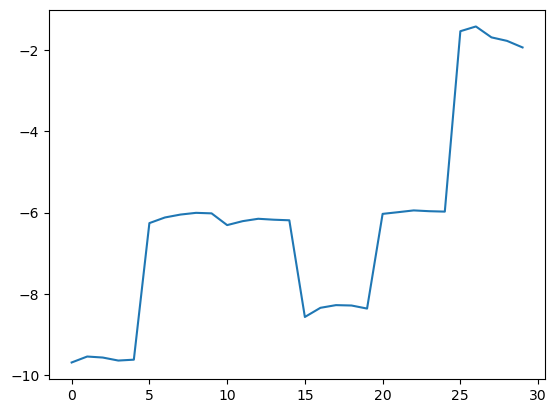

In [448]:
sns.lineplot(log_central_arr)


In [449]:
# take log and diff for each row in entropy_matrix
log_entropy_matrix = np.log(entropy_matrix)
log_other_entropy_matrix = np.log(entropy_other_matrix)
# diff_log_entropy_matrix = np.diff(log_entropy_matrix)

# do same for shifted matrix
log_shift_matrix = np.log(shifted_entropy_matrix)
log_permuted_matrix = np.log(permuted_rows)
# log_permuted_matrix = np.log(permuted_cols)

log_mean_data = np.log(mean_data)

NameError: name 'mean_data' is not defined

In [ ]:
sns.lineplot(log_mean_data)

TypeError: object of type 'numpy.float64' has no len()

<Axes: >

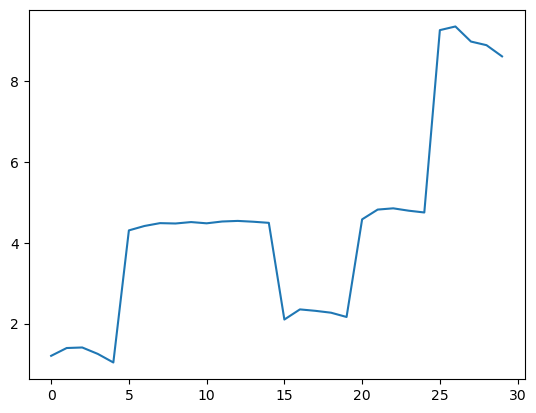

In [ ]:
sns.lineplot(log_entropy_matrix[0])

<Axes: >

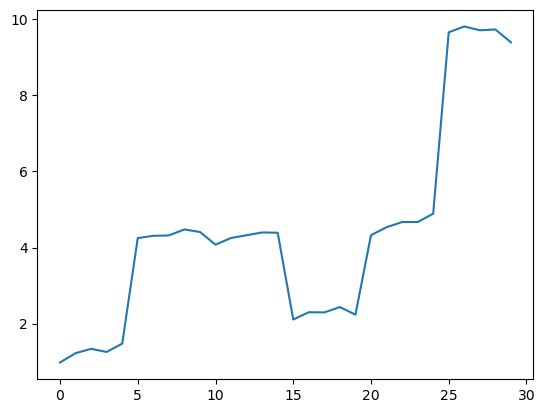

In [ ]:
sns.lineplot(log_entropy_matrix[8])

<Axes: >

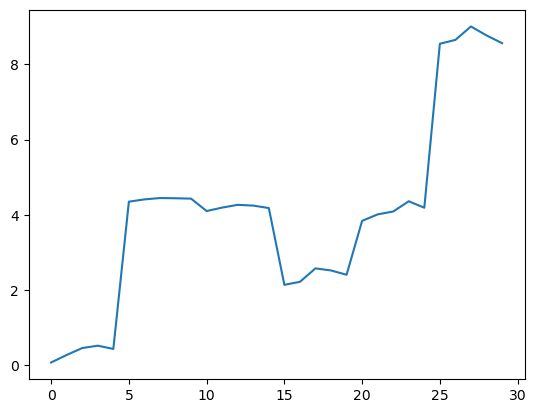

In [ ]:
sns.lineplot(log_permuted_matrix[2])

In [ ]:
# apply entropy based outlier detection
# below are helper functions
def entropy_func(x: float):
    return x * np.log2(x)
def weight_intensity(arr):
    S = scipy.stats.entropy(arr)
    # print(S)
    if S >= 3:
        return arr
    else:
        w = 0.25+S*0.25
        return np.power(arr, w)

def entropy_match(m: float,
                  n: float):
    return entropy_func(m+n) - entropy_func(m) - entropy_func(n)
def normalize_arr(arr: np.array):
    return arr/np.sum(arr)

In [ ]:
def unweighted_entropy_score(arr1: np.array, arr2: np.array):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')
        return
    arr1 = normalize_arr(arr1)
    arr2 = normalize_arr(arr2)
    sum = 0
    for i in range(len(arr1)):
        sum += entropy_match(arr1[i], arr2[i])
    return sum/2
def weigthed_entropy_score(arr1: np.array, arr2: np.array):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')
        return
    arr1 = (normalize_arr(weight_intensity(arr1)))
    arr2 = (normalize_arr(weight_intensity(arr2)))
    sum = 0
    for i in range(len(arr1)):
        sum += entropy_match(arr1[i], arr2[i])
    return sum/2

In [ ]:
# Main function to calculate entropy scores for all pairs of rows
def calculate_entropy_scores(entropy_matrix, weighted=False):
    n_rows = entropy_matrix.shape[0]
    scores = np.zeros((n_rows, n_rows))
    for i in range(n_rows):
        for j in range(i + 1, n_rows):
            score = calculate_entropy_score(entropy_matrix[i], entropy_matrix[j], weighted)
            scores[i, j] = score
            scores[j, i] = score  # Symmetric matrix
    return scores

def calculate_entropy_score(arr1, arr2, weighted):
    if len(arr1) != len(arr2):
        raise ValueError('Length of two arrays should be the same')

    arr1 = normalize_arr(arr1)
    arr2 = normalize_arr(arr2)

    if weighted:
        arr1 = weight_intensity(arr1)
        arr2 = weight_intensity(arr2)

    sum_value = 0
    for i in range(len(arr1)):
        sum_value += entropy_match(arr1[i], arr2[i])
    return sum_value

In [ ]:
# # calculate the scores row by row (trial by trial)
# unweighted_scores = calculate_entropy_scores(entropy_matrix)
# weighted_scores = calculate_entropy_scores(entropy_matrix, weighted=True)

# print("Unweighted Entropy Scores:\n", unweighted_scores)
# print("Weighted Entropy Scores:\n", weighted_scores)

Unweighted Scores reflect the basic differences in distribution without any adjustments for the underlying entropy within each row. This can be useful for straightforward comparisons where each element is considered equally.

Weighted Scores adjust for the entropy of each row before comparison. The weighting increases the influence of rows with lower inherent entropy (less randomness or more predictability) and decreases the influence of those with higher entropy. This can be particularly insightful when you want to account for the inherent randomness or predictability of the data.

Rows that are intrinsically more predictable (lower entropy) will have their differences emphasized when compared to more chaotic (higher entropy) rows.

In [ ]:
# # compare the scores row by row (trial by trial) and find the outlier
# nthreshold = 2 # number of standard deviation to determine the threshold

# entropy_trials = np.array(entropy_trials)
# # Assuming 'weighted_scores' is the weighted entropy scores matrix already loaded
# n_rows = weighted_scores.shape[0]
# average_scores = np.zeros(n_rows)
# max_scores = np.zeros(n_rows)

# # Compute the average and max entropy scores for each trial, ignoring self-comparisons (diagonal)
# for i in range(n_rows):
#     # Include only the upper triangle starting just above the diagonal
#     relevant_scores = weighted_scores[i, i+1:]
#     # Combine with the lower triangle if necessary
#     if i > 0:
#         relevant_scores = np.concatenate((weighted_scores[i, :i], relevant_scores))
#     average_scores[i] = np.mean(relevant_scores)
#     max_scores[i] = np.max(relevant_scores)

# # Determine thresholds to identify outliers
# mean_avg_score = np.mean(average_scores)
# std_avg_score = np.std(average_scores)
# threshold_up = mean_avg_score + nthreshold * std_avg_score 
# threshold_down = mean_avg_score - nthreshold * std_avg_score

# # Identify outlier trials based on average or maximum scores
# outlier_indices_up = np.where(average_scores > threshold_up)[0] 
# outlier_indices_down = np.where(average_scores < threshold_down)[0]
# outlier_trials = entropy_trials[np.union1d(outlier_indices_up, outlier_indices_down)]

# print("Outlier Trials based on Average Scores:", outlier_trials)

In [ ]:
# # create a reference entropy array by normalize all rows in entropy matrix
# ref_entropy_array = np.mean(entropy_matrix, axis=0)
# ref_entropy_array

In [ ]:
# # compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
# unweighted_scores = np.zeros(entropy_matrix.shape[0])
# weighted_scores = np.zeros(entropy_matrix.shape[0])

# for i in range(entropy_matrix.shape[0]):
#     trial_data = entropy_matrix[i]
#     unweighted_scores[i] = unweighted_entropy_score(ref_entropy_array, trial_data)
#     weighted_scores[i] = weigthed_entropy_score(ref_entropy_array, trial_data)

# # print the results
# print("Unweighted Scores:", unweighted_scores)
# print("Weighted Scores:", weighted_scores)

In [ ]:
# # determine the outlier trials based on the scores
# nthreshold = 2 # number of standard deviation to determine the threshold

# mean_unweighted = np.mean(unweighted_scores)
# std_unweighted = np.std(unweighted_scores)
# threshold_unweighted_up = mean_unweighted + nthreshold * std_unweighted
# threshold_unweighted_down = mean_unweighted - nthreshold * std_unweighted

# mean_weighted = np.mean(weighted_scores)
# std_weighted = np.std(weighted_scores)
# threshold_weighted_up = mean_weighted + nthreshold * std_weighted
# threshold_weighted_down = mean_weighted - nthreshold * std_weighted

# outlier_indices_unweighted_up = np.where(unweighted_scores > threshold_unweighted_up)[0]
# outlier_indices_unweighted_down = np.where(unweighted_scores < threshold_unweighted_down)[0]
# outlier_trials_unweighted = entropy_trials[np.union1d(outlier_indices_unweighted_up, outlier_indices_unweighted_down)]

# outlier_indices_weighted_up = np.where(weighted_scores > threshold_weighted_up)[0]
# outlier_indices_weighted_down = np.where(weighted_scores < threshold_weighted_down)[0]

# outlier_trials_weighted =  entropy_trials[np.union1d(outlier_indices_weighted_up, outlier_indices_weighted_down)]

# print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)
# print("Outlier Trials based on Weighted Scores:", outlier_trials_weighted)

In [ ]:
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores = np.zeros(log_entropy_matrix.shape[0])

for i in range(log_entropy_matrix.shape[0]):
    trial_data = log_entropy_matrix[i]
    unweighted_scores[i] = unweighted_entropy_score(log_central_arr, trial_data)

# print the results
print("Unweighted Scores:", unweighted_scores)

Unweighted Scores: [0.82559472 0.79860274 0.78444179 0.81060605 0.81220869 0.81693148
 0.79680289 0.81038689 0.81695242 0.78416336]


In [ ]:
# determine the outlier trials based on the scores
nthreshold = 1 # number of standard deviation to determine the threshold

# Determine outliers based on unweighted scores
mean_unweighted = np.mean(unweighted_scores)
std_unweighted = np.std(unweighted_scores)
threshold_unweighted = mean_unweighted - nthreshold * std_unweighted
outlier_indices_unweighted = np.where(unweighted_scores < threshold_unweighted)[0]
outlier_trials_unweighted = entropy_trials[outlier_indices_unweighted]
print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)

Outlier Trials based on Unweighted Scores: ['ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']


In [ ]:
# try un-log scale data
unweighted_scores = np.zeros(entropy_matrix.shape[0])

for i in range(entropy_matrix.shape[0]):
    trial_data = entropy_matrix[i]
    unweighted_scores[i] = unweighted_entropy_score(mean_data, trial_data)

# print the results
print("Unweighted Scores:", unweighted_scores)

Unweighted Scores: [0.99861325 0.95271444 0.98851836 0.98158707 0.98907711 0.95596368
 0.98827864 0.98489803 0.99521378 0.98814901]


In [ ]:
# determine the outlier trials based on the scores
nthreshold = 1 # number of standard deviation to determine the threshold

# Determine outliers based on unweighted scores
mean_unweighted = np.mean(unweighted_scores)
std_unweighted = np.std(unweighted_scores)
threshold_unweighted = mean_unweighted - nthreshold * std_unweighted
outlier_indices_unweighted = np.where(unweighted_scores < threshold_unweighted)[0]
outlier_trials_unweighted = entropy_trials[outlier_indices_unweighted]
print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)

Outlier Trials based on Unweighted Scores: ['ADNP_T3_11072023' 'KCNT1_T1_08082023']


In [ ]:
# validation of other data with wt data
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores_other = np.zeros(log_other_entropy_matrix.shape[0])

for i in range(log_other_entropy_matrix.shape[0]):
    trial_data = log_other_entropy_matrix[i]
    unweighted_scores_other[i] = unweighted_entropy_score(log_central_arr, trial_data)

# print the results
print("Unweighted Scores (other):", unweighted_scores_other)

Unweighted Scores (other): [0.82400515 0.7912958  0.76985495 0.805327   0.82267339 0.81891141
 0.82961322 0.80980636 0.8166505  0.77236358]


In [ ]:
entropy_trials

array(['ADNP_T2_10262023', 'ADNP_T3_11072023', 'ADNP_T4_C1_06282024',
       'CDKL5-E6D_T1_C1_05152024', 'CHD8_T2_C1_08252023',
       'KCNT1_T1_08082023', 'KCNT1_T3_C1_03122024', 'SHANK3_T1_11222023',
       'SPTAN1_T1_07192023', 'SYNGAP1_T1_C1_03212024'], dtype='<U24')

In [ ]:
threshold_unweighted

0.9675921386002019

In [ ]:
# validation of other data with wt data
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores_other = np.zeros(log_other_entropy_matrix.shape[0])
weighted_scores_other = np.zeros(log_other_entropy_matrix.shape[0])

for i in range(log_other_entropy_matrix.shape[0]):
    trial_data = log_other_entropy_matrix[i]
    unweighted_scores_other[i] = unweighted_entropy_score(log_mean_data, trial_data)
    weighted_scores_other[i] = weigthed_entropy_score(log_mean_data, trial_data)

# print the results
print("Unweighted Scores (other):", unweighted_scores_other)
print("Weighted Scores (other):", weighted_scores_other)

Unweighted Scores (other): [0.99900714 0.99840351 0.9893578  0.99942477 0.99874295 0.99954471
 0.99522784 0.99885526 0.99944462 0.99243952]
Weighted Scores (other): [0.99900714 0.99840351 0.9893578  0.99942477 0.99874295 0.99954471
 0.99522784 0.99885526 0.99944462 0.99243952]


In [ ]:
# validation of shifted data
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores_shift = np.zeros(log_shift_matrix.shape[0])
weighted_scores_shift = np.zeros(log_shift_matrix.shape[0])

for i in range(log_shift_matrix.shape[0]):
    trial_data = log_shift_matrix[i]
    unweighted_scores_shift[i] = unweighted_entropy_score(log_central_arr, trial_data)
    weighted_scores_shift[i] = weigthed_entropy_score(log_central_arr, trial_data)

# print the results
print("Unweighted Scores (shift):", unweighted_scores_shift)
print("Weighted Scores (shift):", weighted_scores_shift)

Unweighted Scores (shift): [0.89422278 0.89929238 0.89906883 0.90217237 0.89824668 0.89317631
 0.89625121 0.89967436 0.88640984 0.89629932]
Weighted Scores (shift): [0.89422278 0.89929238 0.89906883 0.90217237 0.89824668 0.89317631
 0.89625121 0.89967436 0.88640984 0.89629932]


In [ ]:
# validation of permuted data
# compare each trial with the reference entropy array, and calculate weighted and unweighted socres in two output arrays
unweighted_scores_permuted = np.zeros(log_permuted_matrix.shape[0])
weighted_scores_permuted = np.zeros(log_permuted_matrix.shape[0])

for i in range(log_permuted_matrix.shape[0]):
    trial_data = log_permuted_matrix[i]
    unweighted_scores_permuted[i] = unweighted_entropy_score(log_central_arr, trial_data)
    weighted_scores_permuted[i] = weigthed_entropy_score(log_central_arr, trial_data)

# print the results
print("Unweighted Scores (permuted):", unweighted_scores_permuted)
print("Weighted Scores (permuted):", weighted_scores_permuted)

Unweighted Scores (permuted): [0.81220869 0.79680289 0.78416336 0.81060605 0.81695242 0.81693148
 0.82559472 0.81038689 0.79860274 0.78444179]
Weighted Scores (permuted): [0.81220869 0.79680289 0.78416336 0.81060605 0.81695242 0.81693148
 0.82559472 0.81038689 0.79860274 0.78444179]


In [ ]:
entropy_trials

array(['ADNP_T2_10262023', 'ADNP_T3_11072023', 'ADNP_T4_C1_06282024',
       'CDKL5-E6D_T1_C1_05152024', 'CHD8_T2_C1_08252023',
       'KCNT1_T1_08082023', 'KCNT1_T3_C1_03122024', 'SHANK3_T1_11222023',
       'SPTAN1_T1_07192023', 'SYNGAP1_T1_C1_03212024'], dtype='<U24')

In [ ]:
# validate other data
# Determine outliers based on unweighted scores
outlier_indices_unweighted = np.where(unweighted_scores_other < threshold_unweighted)[0]
outlier_trials_unweighted = entropy_trials[outlier_indices_unweighted]
print("Outlier Trials based on Unweighted Scores:", outlier_trials_unweighted)

# Determine outliers based on weighted scores
outlier_indices_weighted = np.where(weighted_scores_other < threshold_weighted)[0]
outlier_trials_weighted = entropy_trials[outlier_indices_weighted]
print("Outlier Trials based on Weighted Scores:", outlier_trials_weighted)

Outlier Trials based on Unweighted Scores: ['ADNP_T3_11072023' 'ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']
Outlier Trials based on Weighted Scores: ['ADNP_T3_11072023' 'ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']


In [ ]:
# validate other data from shifted matrix
# Determine outliers based on unweighted scores
outlier_indices_shifted = np.where(unweighted_scores_shift < threshold_unweighted)[0]
outlier_trials_shifted = entropy_trials[outlier_indices_shifted]
print("Outlier Trials based on shift Scores:", outlier_trials_shifted)


Outlier Trials based on shift Scores: []


In [ ]:
# validate other data from permutated matrix
# Determine outliers based on unweighted scores
outlier_indices_permuted = np.where(unweighted_scores_permuted < threshold_unweighted)[0]
outlier_trials_permuted = entropy_trials[outlier_indices_permuted]
print("Outlier Trials based on permuted Scores:", outlier_trials_permuted)

Outlier Trials based on permuted Scores: ['ADNP_T4_C1_06282024' 'SYNGAP1_T1_C1_03212024']


In [ ]:
def head_to_tail_plot(intensity_1, intensity_2):
    """
    Plots a head-to-tail comparison of two trials.
    """
                      
    
    intensity_1 = np.log10(intensity_1)
    intensity_2 = np.log10(intensity_2)
    intensity_1= np.array([x/np.max(intensity_1) for x in intensity_1])
    intensity_2= np.array([x/np.max(intensity_2) for x in intensity_2])
    fig = plt.figure(figsize = (4, 4))
    plt.subplots_adjust()
    ax = fig.add_subplot()
    for i in range(len(intensity_1)):
        
        plt.vlines(x = i, ymin = 0, ymax = intensity_1[i],color = 'blue')
    for i in range(len(intensity_2)):
        plt.vlines(x = i, ymin = 0, ymax = -intensity_2[i],color = 'r')
            
    
    return(plt)

In [ ]:
entropy_trials

array(['ADNP_T2_10262023', 'ADNP_T3_11072023', 'ADNP_T4_C1_06282024',
       'CDKL5-E6D_T1_C1_05152024', 'CHD8_T2_C1_08252023',
       'KCNT1_T1_08082023', 'KCNT1_T3_C1_03122024', 'SHANK3_T1_11222023',
       'SPTAN1_T1_07192023', 'SYNGAP1_T1_C1_03212024'], dtype='<U24')

<module 'matplotlib.pyplot' from '/Users/liufanling/miniconda3/envs/my_env_39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

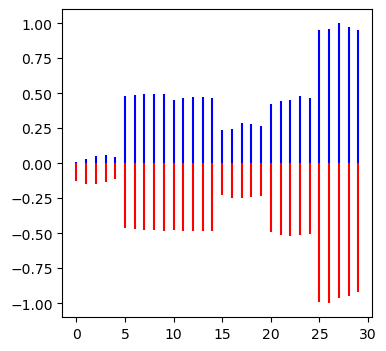

In [ ]:
head_to_tail_plot(entropy_matrix[-1], entropy_matrix[0]) # SYNGAP1_T1_C1_03212024, ADNP_T2_10262023

<module 'matplotlib.pyplot' from '/Users/liufanling/miniconda3/envs/my_env_39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

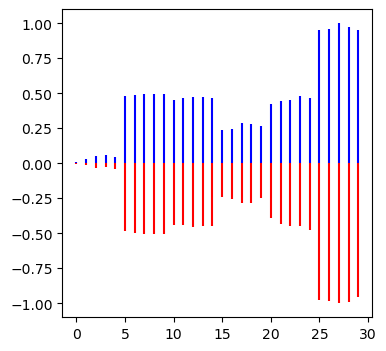

In [ ]:
head_to_tail_plot(entropy_matrix[-1], entropy_other_matrix[-1])